In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
from sklearn.model_selection import train_test_split

from scipy.optimize import leastsq

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
def info(df, head=True):
    print("Type: ", type(df))
    print("Shape: ", df.shape)
    print("Columns: ", df.columns)
    if head:
        display(df.head())
    else:
        display(df)

def corr_vis(df, features, meas='AVERAGEKWH_raw'):
    '''
    Displays a corrrelation chart for the  specified features in the edf
    '''
    ## Create a blank dataframe that calculates all the correlations to TOG
    vis = pd.DataFrame()
    vis['feature'] = features
    vis['spearman'] = [df[f].corr(df[meas], 'spearman') for f in features]
    #[print(str(features[f]) + ": " + str(spr['spearman'][f])) for f in range(len(features))]
    
    vis = vis.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    ax = sns.barplot(data=vis, y='feature', x='spearman', orient='h')
    
    ## Chart design
    ax.set(xlabel='correlation')
    ax.set(title='Correlation of all features to {meas}'.format(meas=meas)) 
    return vis

# Importing GeoDataFrames

California Counties and Boundarise sourced from https://data.ca.gov/dataset/ca-geographic-boundaries

In [ ]:
base = "/datasets/team-red-residential-energy-consumption/datasets/team-red-residential-energy-consumption/Data/"

In [ ]:
cleaned_monthly_with_zip_and_citis_fn = base + "cleaned_data/all-pge-with-nrel/transformed_pge-energy-consumption-with-nrel-solar_2013-2019_136968x35.shp"
zip_cities_monthly_pge_gdf = gpd.read_file(cleaned_monthly_with_zip_and_citis_fn)


In [ ]:
rename_mapper ={
    'TOTALCUSTO': 'TOTALCUSTO_raw',
    'TOTALKWH_r': 'TOTALKWH_raw',
    'AVERAGEKWH': 'AVERAGEKWH_raw',
    'TOTALTHERM': 'TOTALTHERM_raw',
    'AVERAGETHE': 'AVERAGETHERM_raw',
    'Temperatur': 'Temperature_raw', 
    'Solar Zeni': 'Solar_Zenith_Angle_raw',
    'TOTALCUS_1': 'TOTALCUS_std', 
    'TOTALKWH_s': 'TOTALKWH_std', 
    'AVERAGEK_1': 'AVERAGEKWH_std', 
    'TOTALTHE_1': 'TOTALTHERM_std', 
    'AVERAGET_1': 'AVERAGETHERM_std',
    'Wind Spe_1': 'Wind_Speed_std', 
    'Temperat_1': 'Temperature_std',
    'Solar Ze_1': 'Solar_Zenith_Angle_std', 
}
zip_cities_monthly_pge_gdf = zip_cities_monthly_pge_gdf.rename(rename_mapper, axis=1)
zip_cities_monthly_pge_gdf['Solar_Zenith_Angle_raw'] = pd.to_numeric(zip_cities_monthly_pge_gdf['Solar_Zenith_Angle_raw'])
zip_cities_monthly_pge_gdf['Temperature_raw'] = pd.to_numeric(zip_cities_monthly_pge_gdf['Temperature_raw'])

In [ ]:
info(zip_cities_monthly_pge_gdf)

Type:  <class 'geopandas.geodataframe.GeoDataFrame'>
Shape:  (136968, 36)
Columns:  Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')


,zip,city,state,latitude,longitude,timezone,dst,DATE,MONTH,YEAR,...,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std,geometry
0,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-01-01,1,2013,...,-0.590525,-0.46156,-0.348278,-1.198043,-1.373894,-0.709183,-1.894812,-2.255195,1.283431,POINT (-120.84510 39.17703)
1,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-02-01,2,2013,...,-0.590525,-0.46156,-0.348278,-0.621567,-0.990437,-0.041747,-1.837832,-1.881118,0.787489,POINT (-120.84510 39.17703)
2,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-03-01,3,2013,...,-0.590525,-0.46156,-0.348278,-0.341841,0.775179,-0.762886,-1.841878,-1.193114,0.089457,POINT (-120.84510 39.17703)
3,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-04-01,4,2013,...,-0.590525,-0.46156,-0.348278,0.639561,0.659686,0.529226,-1.828112,-0.713287,-0.643372,POINT (-120.84510 39.17703)
4,95717,Gold Run,CA,39.177026,-120.8451,-8,1,2013-05-01,5,2013,...,0.278279,-0.46156,-0.348278,0.985208,0.972799,0.807632,-1.802339,-0.107015,-1.200288,POINT (-120.84510 39.17703)


### Sanity check geographic plots

#### California should look like California

#### PG&E dataset matches pg&e customers
PG&E service area reference: https://www.pge.com/mybusiness/customerservice/otherrequests/treetrimming/territory/

## Overlaying PG&E/NREL in Bay Area Only

Bay Area traditionally consists of [9 counties](https://wikitravel.org/en/Bay_Area_(California)).

<img src='https://wikitravel.org/upload/shared//thumb/b/bc/Bayarea_map.png/900px-Bayarea_map.png' style="width: 300px;">


We will define "Bay Area" as a box that encloses the following coordinates `(lat, long)`:

- South West corner: `(36.897966, -123.433313)`

- North East corner: `(38.593263, -121.381268)`

With these coordinates, we'll need to only consider data in the PG&E/NREL dataset that falls within this region.

In [ ]:
approximate_bay_area_center_lat = 39.5769252
approximate_bay_area_center_long = -122.2833322

## for subsetting the ca counties
bay_area_south_west_lat  = 36.897966    ## vertical
bay_area_south_west_long = -123.433313 ## horizontal
bay_area_north_east_lat  = 38.593263    ## vertical --> closer to north pole => higher values
bay_area_north_east_long = -121.381268 ## horizontal --> west long < east long. west is more negative

## for plotting boundaries
bay_area_limit_south_west_lat  = 36.897966    ## vertical
bay_area_limit_south_west_long = -123.75 ## horizontal
bay_area_limit_north_east_lat  = 38.9    ## vertical --> closer to north pole => higher values
bay_area_limit_north_east_long = -121.2 ## horizontal --> west long < east long. west is more negative


### Filtering Bay Area Only Data


#### Boxing the CA Counties Data

#### Boxing the PG&E/NREL Data

In [ ]:
zip_cities_monthly_pge_gdf.columns

Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry'],
      dtype='object')

In [ ]:
## subset south west
bay_area_monthly_pge_nrel = zip_cities_monthly_pge_gdf[ (bay_area_south_west_long <= zip_cities_monthly_pge_gdf['longitude']) & (bay_area_south_west_lat <= zip_cities_monthly_pge_gdf['latitude']) ]

## subst north east
bay_area_monthly_pge_nrel = bay_area_monthly_pge_nrel[ (bay_area_monthly_pge_nrel['longitude'] <= bay_area_north_east_long) & (bay_area_monthly_pge_nrel['latitude'] <= bay_area_north_east_lat) ]


In [ ]:
## Viewing how many measurements are the box
bay_area_monthly_pge_nrel.shape

(56683, 36)

In [ ]:
bay_area_monthly_pge_nrel.columns
raw_cols = ["MONTH", 'YEAR', 'zip', 'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw']
bay_area_monthly_pge_nrel_raw = bay_area_monthly_pge_nrel[raw_cols]
bay_area_monthly_pge_nrel_raw.head()

,MONTH,YEAR,zip,TOTALCUSTO_raw,TOTALKWH_raw,AVERAGEKWH_raw,TOTALTHERM_raw,AVERAGETHERM_raw,GHI_raw,DHI_raw,DNI_raw,Wind Speed,Temperature_raw,Solar_Zenith_Angle_raw
94,1,2013,94564,6727,3787580,563,0,0,116.13037634408602,29.18010752688172,222.91935483870967,2.123252688172044,7.276882,105.581747
95,2,2013,94564,6725,3086143,459,0,0,162.37946428571428,38.666666666666664,262.79017857142856,2.1078869047619047,9.022321,99.577827
96,3,2013,94564,6715,3091798,460,0,0,190.54569892473117,70.01209677419355,211.2741935483871,2.017607526881722,11.189516,91.109973
97,1,2013,94564,6166,0,0,562494,91,116.13037634408602,29.18010752688172,222.91935483870967,2.123252688172044,7.276882,105.581747
98,2,2013,94564,6172,0,0,388246,63,162.37946428571428,38.666666666666664,262.79017857142856,2.1078869047619047,9.022321,99.577827


In [ ]:
measurment_cols = ["MONTH",'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std']

,feature,spearman
14,AVERAGEKWH_std,-0.773815
3,AVERAGEKWH_raw,-0.773815
2,TOTALKWH_raw,-0.773815
13,TOTALKWH_std,-0.773815
10,Temperature_raw,-0.186410
21,Temperature_std,-0.186410
17,GHI_std,-0.171452
19,DNI_std,-0.164958
8,DNI_raw,-0.162345
18,DHI_std,-0.128625


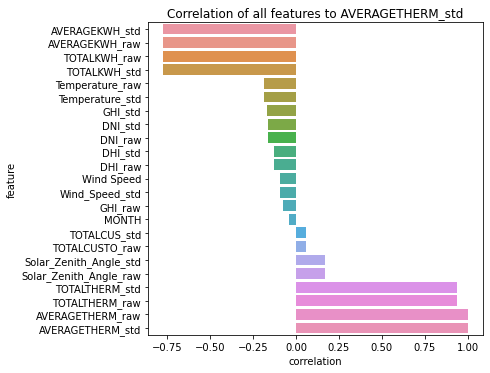

In [ ]:
corr_vis(bay_area_monthly_pge_nrel, measurment_cols, meas='AVERAGETHERM_std')

In [ ]:
X_cols = ['MONTH','YEAR', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed', 'Temperature_raw', 'Solar_Zenith_Angle_raw' ]
bay_area_monthly_elec_pge_nrel = bay_area_monthly_pge_nrel[bay_area_monthly_pge_nrel['TOTALTHERM_raw']==0].drop_duplicates()

## Cutting out using our engineering judgement
bay_area_monthly_elec_pge_nrel = bay_area_monthly_elec_pge_nrel[bay_area_monthly_elec_pge_nrel['zip'] != 94301] ## Cut out Palo Alto, which only has 16 measurements
bay_area_monthly_elec_pge_nrel = bay_area_monthly_elec_pge_nrel[bay_area_monthly_elec_pge_nrel['zip'] != 94035] ## Cut out Mountain View which only has 16 measurements

bay_area_monthly_elec_pge_nrel_clean = bay_area_monthly_elec_pge_nrel[bay_area_monthly_elec_pge_nrel['TOTALKWH_std'] < 10]

## lag for the columns we want
for zipcode in bay_area_monthly_elec_pge_nrel_clean['zip'].values:
    bay_area_monthly_elec_pge_nrel_clean = lag_by_zipcode(bay_area_monthly_elec_pge_nrel_clean, 3, zipcode, zip_col='zip', time_col='DATE')


## Last step before passing data to our model
elec_X_train = bay_area_monthly_elec_pge_nrel_clean[X_cols]

## targetted_y can be changed to predict other values,
targetted_y = 'AVERAGEKWH_raw'
elec_Y_train = bay_area_monthly_elec_pge_nrel_clean[targetted_y]


KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
bay_area_monthly_elec_pge_nrel_clean.head()

,zip,city,state,latitude,longitude,timezone,dst,DATE,MONTH,YEAR,...,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std,geometry
94,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-01-01,1,2013,...,0.434919,-0.46156,-0.348278,-1.104314,-1.395587,-0.577344,0.229490,-1.408347,1.263679,POINT (-122.29208 37.99751)
95,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-02-01,2,2013,...,0.245494,-0.46156,-0.348278,-0.578528,-0.869444,-0.114522,0.211040,-1.108450,0.776013,POINT (-122.29208 37.99751)
96,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-03-01,3,2013,...,0.247315,-0.46156,-0.348278,-0.258319,0.869032,-0.712522,0.102642,-0.736089,0.088214,POINT (-122.29208 37.99751)
100,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-04-01,4,2013,...,0.176281,-0.46156,-0.348278,0.704267,0.491066,0.607951,0.538100,-0.322403,-0.634085,POINT (-122.29208 37.99751)
101,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-05-01,5,2013,...,0.185388,-0.46156,-0.348278,1.130906,0.761388,0.955463,0.888261,-0.024109,-1.182103,POINT (-122.29208 37.99751)


In [ ]:
def lag_by_zipcode(full_df, L, zipcode, zip_col='zip', time_col='DATE'):
    desired_cols = ['Temperature_raw', 'Wind Speed', 'GHI_raw', 'DNI_raw']
    subsetted_cols = [zip_col] + desired_cols
    subsetted_zip = full_df[full_df[zip_col] == zipcode].sort_values(by=time_col)[subsetted_cols]

    ## Lag for the columns we want
    for lag in range(1,L+1):
        for c in desired_cols:
            new_col_name = c + " lag l=%i"%(lag)
            subsetted_zip[new_col_name] = subsetted_zip[c].shift(lag).tolist()

    merged = pd.merge(left=full_df, right=subsetted_zip, left_on=subsetted_cols, right_on=subsetted_cols, how='left')
    return merged

    

In [ ]:
bay_area_monthly_elec_pge_nrel_clean.head(50)

,zip,city,state,latitude,longitude,timezone,dst,DATE,MONTH,YEAR,...,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std,geometry
94,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-01-01,1,2013,...,0.434919,-0.46156,-0.348278,-1.104314,-1.395587,-0.577344,0.229490,-1.408347,1.263679,POINT (-122.29208 37.99751)
95,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-02-01,2,2013,...,0.245494,-0.46156,-0.348278,-0.578528,-0.869444,-0.114522,0.211040,-1.108450,0.776013,POINT (-122.29208 37.99751)
96,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-03-01,3,2013,...,0.247315,-0.46156,-0.348278,-0.258319,0.869032,-0.712522,0.102642,-0.736089,0.088214,POINT (-122.29208 37.99751)
100,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-04-01,4,2013,...,0.176281,-0.46156,-0.348278,0.704267,0.491066,0.607951,0.538100,-0.322403,-0.634085,POINT (-122.29208 37.99751)
101,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-05-01,5,2013,...,0.185388,-0.46156,-0.348278,1.130906,0.761388,0.955463,0.888261,-0.024109,-1.182103,POINT (-122.29208 37.99751)
102,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-06-01,6,2013,...,0.203602,-0.46156,-0.348278,1.205794,0.528041,1.106355,0.707365,0.298288,-1.422509,POINT (-122.29208 37.99751)
106,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-07-01,7,2013,...,0.205423,-0.46156,-0.348278,1.114159,0.797766,0.906800,0.432350,0.335923,-1.297698,POINT (-122.29208 37.99751)
107,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-08-01,8,2013,...,0.209066,-0.46156,-0.348278,0.885443,0.123502,0.986730,0.428154,0.420215,-0.833733,POINT (-122.29208 37.99751)
108,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-09-01,9,2013,...,0.189031,-0.46156,-0.348278,0.344658,-0.547457,0.748892,0.395684,0.443855,-0.158411,POINT (-122.29208 37.99751)
112,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-10-01,10,2013,...,0.196316,-0.46156,-0.348278,-0.290836,-0.901723,0.245906,-0.218190,-0.092928,0.566284,POINT (-122.29208 37.99751)


In [ ]:
pinole= lag_by_zipcode(bay_area_monthly_elec_pge_nrel_clean, 3, 94564, zip_col='zip', time_col='DATE')
pinole.columns

Index(['zip', 'city', 'state', 'latitude', 'longitude', 'timezone', 'dst',
       'DATE', 'MONTH', 'YEAR', 'DAY', 'CUSTOMERCL', 'COMBINED',
       'TOTALCUSTO_raw', 'TOTALKWH_raw', 'AVERAGEKWH_raw', 'TOTALTHERM_raw',
       'AVERAGETHERM_raw', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'TOTALCUS_std',
       'TOTALKWH_std', 'AVERAGEKWH_std', 'TOTALTHERM_std', 'AVERAGETHERM_std',
       'GHI_std', 'DHI_std', 'DNI_std', 'Wind_Speed_std', 'Temperature_std',
       'Solar_Zenith_Angle_std', 'geometry', 'Temperature_raw lag l=1',
       'Wind Speed lag l=1', 'GHI_raw lag l=1', 'DNI_raw lag l=1',
       'Temperature_raw lag l=2', 'Wind Speed lag l=2', 'GHI_raw lag l=2',
       'DNI_raw lag l=2', 'Temperature_raw lag l=3', 'Wind Speed lag l=3',
       'GHI_raw lag l=3', 'DNI_raw lag l=3'],
      dtype='object')

In [ ]:
pinole[['Temperature_raw', 'Wind Speed', 'GHI_raw', 'DNI_raw', 'Temperature_raw lag l=1',
       'Wind Speed lag l=1', 'GHI_raw lag l=1', 'DNI_raw lag l=1',
       'Temperature_raw lag l=2', 'Wind Speed lag l=2', 'GHI_raw lag l=2',
       'DNI_raw lag l=2', 'Temperature_raw lag l=3', 'Wind Speed lag l=3',
       'GHI_raw lag l=3', 'DNI_raw lag l=3']]

,Temperature_raw,Wind Speed,GHI_raw,DNI_raw,Temperature_raw lag l=1,Wind Speed lag l=1,GHI_raw lag l=1,DNI_raw lag l=1,Temperature_raw lag l=2,Wind Speed lag l=2,GHI_raw lag l=2,DNI_raw lag l=2,Temperature_raw lag l=3,Wind Speed lag l=3,GHI_raw lag l=3,DNI_raw lag l=3
0,7.276882,2.123252688172044,116.13037634408602,222.91935483870967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.022321,2.1078869047619047,162.37946428571428,262.79017857142856,7.276882,2.123252688172044,116.13037634408602,222.91935483870967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.189516,2.017607526881722,190.54569892473117,211.2741935483871,9.022321,2.1078869047619047,162.37946428571428,262.79017857142856,7.276882,2.123252688172044,116.13037634408602,222.91935483870967,NaN,NaN,NaN,NaN
3,13.597222,2.380277777777777,275.21666666666664,325.02916666666664,11.189516,2.017607526881722,190.54569892473117,211.2741935483871,9.022321,2.1078869047619047,162.37946428571428,262.79017857142856,7.276882,2.123252688172044,116.13037634408602,222.91935483870967
4,15.333333,2.6719086021505336,312.744623655914,354.96639784946234,13.597222,2.380277777777777,275.21666666666664,325.02916666666664,11.189516,2.017607526881722,190.54569892473117,211.2741935483871,9.022321,2.1078869047619047,162.37946428571428,262.79017857142856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29853,24.378091,3.0030913978494644,312.28225806451616,389.9220430107527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29854,22.098333,2.5294444444444415,250.71805555555557,342.4819444444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29855,18.005780,1.9706989247311848,199.41397849462365,314.4139784946237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29856,13.942639,1.5990277777777768,128.82222222222222,226.15277777777777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pinole[[]]

In [ ]:
bay_area_monthly_elec_pge_nrel_clean.head()

,zip,city,state,latitude,longitude,timezone,dst,DATE,MONTH,YEAR,...,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std,geometry
94,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-01-01,1,2013,...,0.434919,-0.46156,-0.348278,-1.104314,-1.395587,-0.577344,0.229490,-1.408347,1.263679,POINT (-122.29208 37.99751)
95,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-02-01,2,2013,...,0.245494,-0.46156,-0.348278,-0.578528,-0.869444,-0.114522,0.211040,-1.108450,0.776013,POINT (-122.29208 37.99751)
96,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-03-01,3,2013,...,0.247315,-0.46156,-0.348278,-0.258319,0.869032,-0.712522,0.102642,-0.736089,0.088214,POINT (-122.29208 37.99751)
100,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-04-01,4,2013,...,0.176281,-0.46156,-0.348278,0.704267,0.491066,0.607951,0.538100,-0.322403,-0.634085,POINT (-122.29208 37.99751)
101,94564,Pinole,CA,37.997509,-122.29208,-8,1,2013-05-01,5,2013,...,0.185388,-0.46156,-0.348278,1.130906,0.761388,0.955463,0.888261,-0.024109,-1.182103,POINT (-122.29208 37.99751)


In [ ]:
#elec_X_train_2=elec_X_train[4:]

NameError: name 'elec_X_train' is not defined

In [ ]:
elec_X_train_2 = elec_X_train_2.reset_index()

In [ ]:
elec_X_train_2.head()

,index,MONTH,YEAR,zip,GHI_raw,DHI_raw,DNI_raw,Wind Speed,Temperature_raw,Solar_Zenith_Angle_raw,...,k_10,k_9,k_8,k_7,k_6,k_5,k_4,k_3,k_2,k_1
0,118,1,2014,94564,116.11290322580645,31.026881720430108,218.20698924731184,1.7182795698924735,10.813172,105.615659,...,460,421,426,436,437,439,428,432,462,572
1,119,2,2014,94564,125.19047619047619,49.552083333333336,158.35565476190476,2.0611607142857156,10.925595,99.640179,...,421,426,436,437,439,428,432,462,572,492
2,120,3,2014,94564,189.59543010752688,59.608870967741936,227.41397849462365,2.112903225806453,12.837366,91.183226,...,426,436,437,439,428,432,462,572,492,431
3,124,4,2014,94564,265.2611111111111,71.5,294.6666666666667,2.219722222222223,13.569444,82.282472,...,436,437,439,428,432,462,572,492,431,434
4,125,5,2014,94564,325.43951612903226,74.29032258064517,363.5766129032258,2.526478494623656,16.032258,75.510699,...,437,439,428,432,462,572,492,431,434,407


In [ ]:
elec_X_train_2 = elec_X_train_2.set_index('index')

In [ ]:
elec_Y_train.mean()

457.2335485554034

In [ ]:
bay_area_monthly_elec_pge_nrel_clean.describe()

,zip,latitude,longitude,MONTH,YEAR,DAY,TOTALCUSTO_raw,TOTALKWH_raw,AVERAGEKWH_raw,TOTALTHERM_raw,...,TOTALKWH_std,AVERAGEKWH_std,TOTALTHERM_std,AVERAGETHERM_std,GHI_std,DHI_std,DNI_std,Wind_Speed_std,Temperature_std,Solar_Zenith_Angle_std
count,30666.000000,30666.000000,30666.000000,30666.000000,30666.000000,30666.0,30666.000000,3.066600e+04,30666.000000,30666.0,...,30666.000000,30666.000000,3.066600e+04,3.066600e+04,30666.000000,30666.000000,30666.000000,30666.000000,30666.000000,30666.000000
mean,94737.878334,37.787116,-122.193570,6.479978,2015.786148,1.0,8087.939640,3.789959e+06,457.233549,0.0,...,0.739082,0.242276,-4.615598e-01,-3.482781e-01,-0.021728,0.032543,-0.054321,0.404610,-0.157148,-0.000645
std,459.910261,0.409973,0.356654,3.484611,2.021453,0.0,6908.315981,3.359593e+06,253.135856,0.0,...,1.135282,0.461059,1.110241e-16,5.551206e-17,0.970710,1.016678,0.942242,0.892265,0.673367,0.998189
min,94002.000000,36.922902,-123.229380,1.000000,2013.000000,1.0,0.000000,0.000000e+00,0.000000,0.0,...,-0.541630,-0.590525,-4.615598e-01,-3.482781e-01,-1.726467,-1.718965,-2.201362,-1.289944,-2.198615,-1.435575
25%,94512.000000,37.444879,-122.430100,3.000000,2014.000000,1.0,918.000000,5.522408e+05,350.000000,0.0,...,-0.355016,0.046962,-4.615598e-01,-3.482781e-01,-1.019955,-0.923597,-0.700843,-0.218190,-0.662881,-0.844779
50%,94613.000000,37.792678,-122.189940,6.000000,2016.000000,1.0,7409.500000,3.377306e+06,457.000000,0.0,...,0.599637,0.241851,-4.615598e-01,-3.482781e-01,-0.117098,0.039015,-0.066122,0.300822,-0.248118,0.082091
75%,95060.000000,38.031271,-121.950720,10.000000,2018.000000,1.0,13354.750000,5.984426e+06,575.000000,0.0,...,1.480642,0.456775,-4.615598e-01,-3.482781e-01,0.834873,0.818535,0.681497,0.892618,0.384143,1.130657
max,95823.000000,38.592155,-121.400220,12.000000,2019.000000,1.0,110585.000000,2.436159e+07,2401.000000,0.0,...,7.690700,3.782636,-4.615598e-01,-3.482781e-01,1.748295,4.262493,2.286722,4.351489,2.065529,1.424365


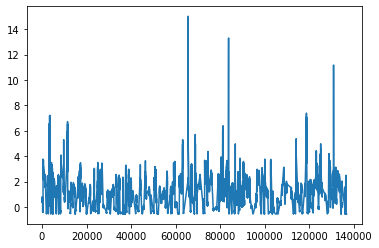

In [ ]:
 plt.plot(bay_area_monthly_elec_pge_nrel['TOTALKWH_std'])
#keep this plot!! shows why we got rid of the data (and make prettier)
 #plt.plot(bay_area_monthly_elec_pge_nrel_clean['TOTALKWH_std']) #add this plot to it side by side to show
 

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TOTALKWH_std', ylabel='Density'>

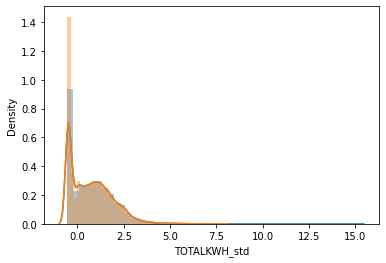

In [ ]:
sns.distplot(bay_area_monthly_elec_pge_nrel['TOTALKWH_std'])
sns.distplot(bay_area_monthly_elec_pge_nrel_clean['TOTALKWH_std'])


In [ ]:
## Trainv-validation split 
X_train, X_val, y_train, y_val = train_test_split(elec_X_train_2,elec_Y_train_2,test_size=0.2,
                                                  random_state=0)



In [ ]:
info(X_train)

Type:  <class 'pandas.core.frame.DataFrame'>
Shape:  (24447, 21)
Columns:  Index(['MONTH', 'YEAR', 'zip', 'GHI_raw', 'DHI_raw', 'DNI_raw', 'Wind Speed',
       'Temperature_raw', 'Solar_Zenith_Angle_raw', 'k_12', 'k_11', 'k_10',
       'k_9', 'k_8', 'k_7', 'k_6', 'k_5', 'k_4', 'k_3', 'k_2', 'k_1'],
      dtype='object')


,MONTH,YEAR,zip,GHI_raw,DHI_raw,DNI_raw,Wind Speed,Temperature_raw,Solar_Zenith_Angle_raw,k_12,...,k_10,k_9,k_8,k_7,k_6,k_5,k_4,k_3,k_2,k_1
index,,,,,,,,,,,,,,,,,,,,,
3430,8,2016,94513,311.5416666666667,56.954301075268816,388.14112903225805,3.6731182795698896,19.963710,79.835995,974,...,631,563,694,634,479,485,443,571,902,1014
124974,1,2014,94531,119.76747311827957,31.557795698924732,223.4798387096774,1.5842741935483884,9.915323,105.598199,711,...,588,613,727,978,1127,967,815,597,602,732
114710,10,2013,94518,195.75940860215053,36.64247311827957,315.26881720430106,2.06935483870968,15.620968,96.992312,424,...,557,635,504,499,491,535,662,729,641,577
118070,7,2019,94585,347.9959677419355,54.361559139784944,434.11155913978496,3.0524193548387135,21.367742,73.914301,658,...,516,477,502,579,545,498,470,433,416,591
136436,7,2017,94582,352.0739247311828,51.63306451612903,443.46639784946234,3.777688172043008,18.498656,74.104409,602,...,519,467,483,592,573,467,447,408,458,547


In [ ]:
X_train[20:30]

,MONTH,YEAR,zip,GHI_raw,DHI_raw,DNI_raw,Wind Speed,Temperature_raw,Solar_Zenith_Angle_raw,k_12,...,k_10,k_9,k_8,k_7,k_6,k_5,k_4,k_3,k_2,k_1
index,,,,,,,,,,,,,,,,,,,,,
19691,4,2014,94547,267.1625,71.84166666666667,297.24861111111113,2.219722222222223,13.443056,82.282306,447,...,491,486,494,478,462,486,576,508,448,457
52160,7,2017,94548,349.78629032258067,52.84139784946237,439.2943548387097,3.777688172043008,21.513441,74.060524,0,...,0,678,790,1068,0,0,0,1273,1207,981
40799,9,2017,94545,219.35555555555555,68.72361111111111,255.56805555555556,2.1577777777777767,20.936111,88.091903,447,...,590,581,464,455,417,420,423,436,446,466
45662,2,2016,95065,166.38839285714286,42.919642857142854,261.88988095238096,0.9751488095238084,12.376488,99.636190,530,...,506,506,446,454,463,457,488,612,731,678
86773,12,2019,94612,74.18010752688173,32.513440860215056,116.68682795698925,2.409005376344085,11.286962,107.313132,372,...,382,338,2401,1568,260,263,268,260,261,297
7969,10,2016,94107,148.0483870967742,47.51209677419355,200.73387096774192,2.0556451612903226,15.922043,97.049570,292,...,417,418,309,321,282,284,266,273,276,273
101236,4,2018,94002,255.01527777777778,75.4125,275.0652777777778,3.7051388888888885,13.073056,82.299194,367,...,365,375,399,399,389,419,502,477,401,435
128722,2,2013,94550,162.67113095238096,39.302083333333336,261.0684523809524,1.562351190476193,7.650298,99.532827,699,...,520,530,729,838,867,658,538,609,755,700
82900,7,2016,94568,348.2123655913978,52.060483870967744,432.9045698924731,2.9663978494623624,18.377688,74.142567,539,...,547,478,480,562,517,421,434,395,429,510


### Simple Linear Regression

$$ \hat{\vec{y}} = \hat{\vec\beta}*\vec{x}$$

Coefficients in $ \hat{\vec\beta}$  are simply scalars that are fit to the best-fit line. That is, simply solving least squares

$$ \hat{\vec\beta} = (X^TX)^{-1}X^TY$$


In [ ]:
lm = LinearRegression() #linear regression
lm.fit(X_train, y_train)

## apply model to training data
lm_train_pred = lm.predict(X_train)
lm_train_mse = mean_squared_error(y_true=y_train, y_pred=lm_train_pred)

## apply model to test data
lm_test_pred = lm.predict(X_val)
lm_test_mse = mean_squared_error(y_true=y_val, y_pred=lm_test_pred)
print("Training MSE", lm_train_mse)
print("Testing MSE", lm_test_mse)

Training MSE 7115.622835917434
Testing MSE 7186.677035610138


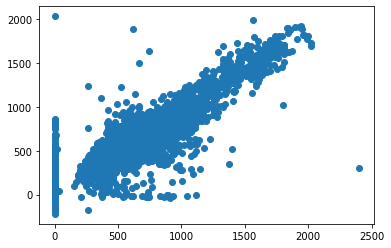

In [ ]:
plt.scatter(y_train, lm_train_pred)

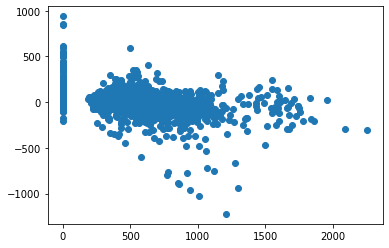

In [ ]:
plt.scatter(y_val, lm_test_pred-y_val)

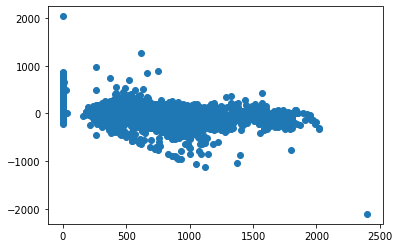

In [ ]:
plt.scatter(y_train, lm_train_pred-y_train)

In [ ]:
svr_regr = svm.SVR() #vector regression
svr_regr.fit(X_train, y_train)

SVR()

In [ ]:
## apply model to training data
svr_train_pred = svr_regr.predict(X_train)
svr_train_mse = mean_squared_error(y_true=y_train, y_pred=svr_train_pred)

## apply model to test data
svr_test_pred = svr_regr.predict(X_val)
svr_test_mse = mean_squared_error(y_true=y_val, y_pred=svr_test_pred)
print("Training MSE", svr_train_mse)
print("Testing MSE", svr_test_mse)

Training MSE 62567.08645346371
Testing MSE 63195.15875780805


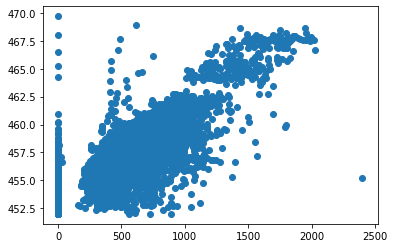

In [ ]:
plt.scatter(y_train, svr_train_pred)

### Decision Tree Regression Model

In [ ]:
X_train.head()

,MONTH,YEAR,zip,GHI_raw,DHI_raw,DNI_raw,Wind Speed,Temperature_raw,Solar_Zenith_Angle_raw
73651,8,2019,94553,310.8225806451613,52.57258064516129,390.7110215053763,3.478360215053763,21.969758,79.630511
105904,3,2016,94940,169.7701612903226,59.166666666666664,192.32930107526883,4.809543010752688,12.182796,91.029530
12682,5,2013,95041,319.7204301075269,70.51344086021506,356.9623655913978,1.1791666666666678,14.376344,75.661573
50030,2,2015,94038,142.48958333333334,42.811011904761905,209.26934523809524,3.3116071428571443,13.616071,99.641830
14991,3,2018,95017,176.4959677419355,59.86021505376344,205.48924731182797,3.0182795698924756,11.216667,91.141855


In [ ]:
dtree = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

In [ ]:
## apply model to training data
dtree_train_pred = dtree.predict(X_train)
dtree_train_mse = mean_squared_error(y_true=y_train, y_pred=dtree_train_pred)

## apply model to test data
dtree_test_pred = dtree.predict(X_val)
dtree_test_mse = mean_squared_error(y_true=y_val, y_pred=dtree_test_pred)
print("Training MSE", dtree_train_mse)
print("Testing MSE", dtree_test_mse)

Training MSE 57941.3605849463
Testing MSE 60557.37234921501


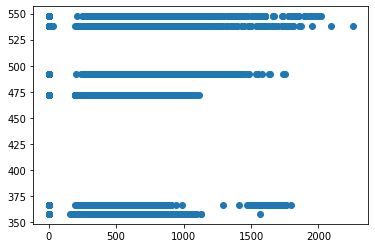

In [ ]:
plt.scatter(y_train, dtree_train_pred)

In [ ]:
### Standardized SVR

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('svr', svm.SVR())])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

In [ ]:
pipe.score(X_val, y_val)

0.0691449342717636

In [ ]:
pipe.score(X_train, y_train)

0.08866927190156293

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c2f0e727-e6a4-4b2a-b180-a91c3a609ecf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>